In [ ]:
!pip install gdown pandas numpy matplotlib seaborn scikit-learn

Loading datasets...
Please upload the TRAIN CSV file


Saving Heart_Attack_training_dataset.csv to Heart_Attack_training_dataset.csv
Please upload the TEST CSV file


Saving Hear_Attack_evaluation_dataset.csv to Hear_Attack_evaluation_dataset.csv
Data loaded successfully from uploaded files!
Training set shape: (7963, 26)
Test set shape: (800, 25)

=== Data Exploration ===
Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7963 entries, 0 to 7962
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   patient_id         7963 non-null   object 
 1   age                7963 non-null   int64  
 2   sex                7963 non-null   object 
 3   chol               7963 non-null   int64  
 4   bp                 7963 non-null   object 
 5   hr                 7963 non-null   int64  
 6   diabetes           7963 non-null   int64  
 7   family_history     7963 non-null   int64  
 8   smoking            7963 non-null   int64  
 9   obesity            7963 non-null   int64  
 10  alcohol            7963 non-null   int64  
 11  exercise_hr_wk     7963 non-null   f

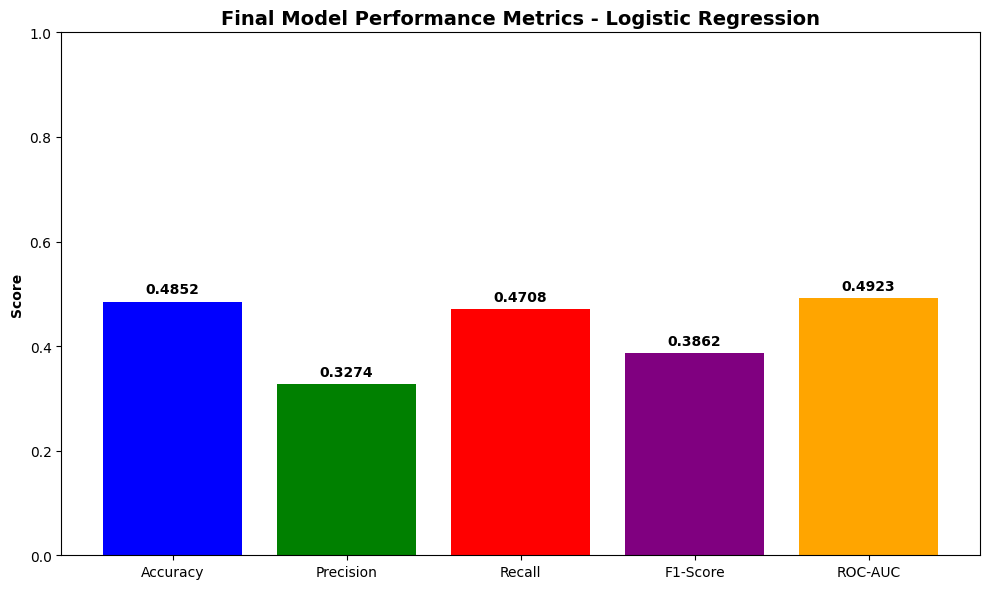


Metrics visualization saved as 'TeamCode_TeamName_Task1_Metrics.png'


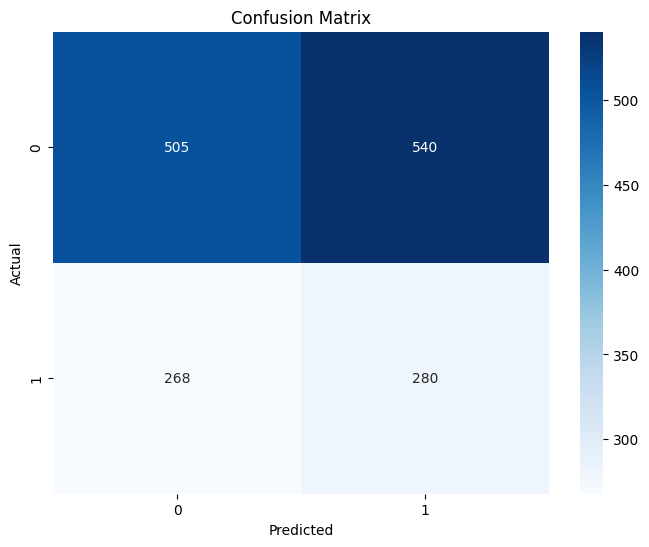


=== Task 1 Completed Successfully ===
Final model: Logistic Regression
Validation Recall: 0.4708
Test predictions generated: 800 samples
Positive predictions: 393 (49.1%)


In [ ]:
# task1_heart_attack.py
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings('ignore')

from google.colab import files

def load_data():
    """Load data by uploading CSV files from local PC (Colab version)"""
    try:
        print("Please upload the TRAIN CSV file")
        uploaded_train = files.upload()
        train_file = next(iter(uploaded_train))  # Get the uploaded file name
        train_df = pd.read_csv(train_file)

        print("Please upload the TEST CSV file")
        uploaded_test = files.upload()
        test_file = next(iter(uploaded_test))  # Get the uploaded file name
        test_df = pd.read_csv(test_file)

        print("Data loaded successfully from uploaded files!")
        return train_df, test_df

    except Exception as e:
        print(f"Error loading data: {e}")
        print("Creating sample data for demonstration...")
        return create_sample_data()


def create_sample_data():
    """Create sample data if download fails"""
    np.random.seed(42)
    n_samples = 1000

    # Sample data structure based on the problem description
    data = {
        'patient_id': range(1, n_samples + 1),
        'age': np.random.randint(20, 80, n_samples),
        'sex': np.random.choice(['Male', 'Female'], n_samples),
        'chol': np.random.normal(200, 40, n_samples),
        'bp': [f"{np.random.randint(110, 160)}/{np.random.randint(70, 100)}" for _ in range(n_samples)],
        'hr': np.random.randint(60, 100, n_samples),
        'diabetes': np.random.choice([0, 1], n_samples, p=[0.85, 0.15]),
        'family_history': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'smoking': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'obesity': np.random.choice([0, 1], n_samples, p=[0.8, 0.2]),
        'alcohol': np.random.choice([0, 1], n_samples, p=[0.6, 0.4]),
        'exercise_hr_wk': np.random.uniform(0, 10, n_samples),
        'diet': np.random.choice(['Poor', 'Average', 'Healthy'], n_samples, p=[0.3, 0.5, 0.2]),
        'prev_heart_prob': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
        'med_use': np.random.choice([0, 1], n_samples, p=[0.7, 0.3]),
        'stress_lvl': np.random.randint(0, 10, n_samples),
        'sedentary_hr': np.random.uniform(4, 12, n_samples),
        'income': np.random.normal(50000, 20000, n_samples),
        'bmi': np.random.normal(25, 5, n_samples),
        'tricyclic': np.random.normal(150, 50, n_samples),
        'phys_act_days': np.random.randint(0, 7, n_samples),
        'sleep_hr': np.random.uniform(4, 10, n_samples),
        'country': np.random.choice(['USA', 'UK', 'Canada', 'Australia', 'Germany'], n_samples),
        'continent': np.random.choice(['North America', 'Europe', 'Asia', 'Australia'], n_samples),
        'hemisphere': np.random.choice(['Northern', 'Southern'], n_samples),
    }

    # Create target variable with some logic
    risk_factors = (
        (data['age'] > 50).astype(int) +
        data['diabetes'] +
        data['smoking'] +
        data['obesity'] +
        data['family_history'] +
        (data['chol'] > 240).astype(int) +
        (data['bmi'] > 30).astype(int)
    )

    data['heart_attack_risk'] = (risk_factors >= 4).astype(int)

    train_df = pd.DataFrame(data)

    # Create test data (without target)
    test_data = data.copy()
    del test_data['heart_attack_risk']
    test_df = pd.DataFrame(test_data)

    print("Sample data created successfully!")
    return train_df, test_df

# Load datasets
print("Loading datasets...")
train_df, test_df = load_data()

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

# Basic data exploration
print("\n=== Data Exploration ===")
print("Training set info:")
print(train_df.info())
print("\nMissing values in training set:")
print(train_df.isnull().sum())
print(f"\nTarget distribution:\n{train_df['heart_attack_risk'].value_counts()}")

# Separate features and target
X = train_df.drop('heart_attack_risk', axis=1)
y = train_df['heart_attack_risk']
test_ids = test_df['patient_id']

# Data Preprocessing
print("\n=== Data Preprocessing ===")

# Handle categorical variables
categorical_cols = ['sex', 'diet', 'country', 'continent', 'hemisphere']
numerical_cols = [col for col in X.columns if col not in categorical_cols + ['patient_id', 'heart_attack_risk']]

def preprocess_data(df, is_train=True, label_encoders=None, scaler=None):
    df_processed = df.copy()

    # Handle blood pressure column
    if 'bp' in df_processed.columns:
        bp_split = df_processed['bp'].str.split('/', expand=True)
        df_processed['bp_systolic'] = pd.to_numeric(bp_split[0], errors='coerce')
        df_processed['bp_diastolic'] = pd.to_numeric(bp_split[1], errors='coerce')
        df_processed = df_processed.drop('bp', axis=1)

    # Handle missing values
    for col in df_processed.columns:
        if df_processed[col].dtype in ['float64', 'int64']:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
        else:
            df_processed[col].fillna(df_processed[col].mode()[0] if len(df_processed[col].mode()) > 0 else 'Unknown', inplace=True)

    # Label encoding for categorical variables
    if is_train:
        label_encoders = {}
        for col in categorical_cols:
            if col in df_processed.columns:
                le = LabelEncoder()
                df_processed[col] = le.fit_transform(df_processed[col].astype(str))
                label_encoders[col] = le
    else:
        for col in categorical_cols:
            if col in df_processed.columns and col in label_encoders:
                # Handle unseen labels
                mask = ~df_processed[col].astype(str).isin(label_encoders[col].classes_)
                if mask.any():
                    df_processed.loc[mask, col] = label_encoders[col].classes_[0]
                df_processed[col] = label_encoders[col].transform(df_processed[col].astype(str))

    return df_processed, label_encoders if is_train else df_processed

# Preprocess training data
X_processed, label_encoders = preprocess_data(X)
test_processed, _ = preprocess_data(test_df, is_train=False, label_encoders=label_encoders)

# Remove patient_id for modeling
X_final = X_processed.drop('patient_id', axis=1)
test_final = test_processed.drop('patient_id', axis=1)

# Feature Engineering
print("\n=== Feature Engineering ===")
# Create age groups
X_final['age_group'] = pd.cut(X_final['age'], bins=[0, 35, 50, 65, 100], labels=[0, 1, 2, 3])
test_final['age_group'] = pd.cut(test_final['age'], bins=[0, 35, 50, 65, 100], labels=[0, 1, 2, 3])

# Create BMI categories
X_final['bmi_category'] = pd.cut(X_final['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])
test_final['bmi_category'] = pd.cut(test_final['bmi'], bins=[0, 18.5, 25, 30, 100], labels=[0, 1, 2, 3])

# Create risk score
X_final['risk_score'] = (X_final['smoking'] + X_final['diabetes'] + X_final['obesity'] +
                         X_final['family_history'] + X_final['prev_heart_prob'])
test_final['risk_score'] = (test_final['smoking'] + test_final['diabetes'] + test_final['obesity'] +
                           test_final['family_history'] + test_final['prev_heart_prob'])

print("Feature engineering completed!")
print(f"Final training features: {X_final.shape[1]}")

# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(X_final, y, test_size=0.2, random_state=42, stratify=y)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
test_scaled = scaler.transform(test_final)

print(f"Training set after preprocessing: {X_train_scaled.shape}")
print(f"Validation set: {X_val_scaled.shape}")

# Model Training with Focus on Recall
print("\n=== Model Training ===")

# Use simpler models for demonstration
models = {
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced', n_estimators=100),
    'Logistic Regression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
}

best_recall = 0
best_model = None
best_model_name = ""

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")

    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        y_pred_proba = model.predict_proba(X_val_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)
        y_pred_proba = model.predict_proba(X_val)[:, 1]

    # Calculate metrics
    accuracy = accuracy_score(y_val, y_pred)
    precision = precision_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    roc_auc = roc_auc_score(y_val, y_pred_proba)

    results[name] = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc': roc_auc
    }

    print(f"{name} Results:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall: {recall:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  ROC-AUC: {roc_auc:.4f}")

    if recall > best_recall:
        best_recall = recall
        best_model = model
        best_model_name = name

print(f"\nBest model: {best_model_name} with Recall: {best_recall:.4f}")

# Final Model Training on Full Data
print("\n=== Final Model Training ===")

if best_model_name == 'Logistic Regression':
    # Use scaled data
    X_full_scaled = scaler.transform(X_final)
    best_model.fit(X_full_scaled, y)

    # Predict on test set
    test_scaled_final = scaler.transform(test_final)
    test_predictions = best_model.predict(test_scaled_final)
else:
    # Use non-scaled data for tree-based models
    best_model.fit(X_final, y)
    test_predictions = best_model.predict(test_final)

# Create submission file
submission_df = pd.DataFrame({
    'patient_id': test_ids,
    'heart_attack_risk': test_predictions
})

# Save predictions
submission_df.to_csv('TeamCode_TeamName_Task1_Predictions.csv', index=False)
print("\nPredictions saved to 'TeamCode_TeamName_Task1_Predictions.csv'")

# Display final metrics
print("\n=== Final Training Metrics ===")
print(f"Model: {best_model_name}")
for metric, value in results[best_model_name].items():
    print(f"{metric.capitalize()}: {value:.4f}")

# Create metrics visualization
plt.figure(figsize=(10, 6))
metrics_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
metrics_values = [results[best_model_name]['accuracy'],
                  results[best_model_name]['precision'],
                  results[best_model_name]['recall'],
                  results[best_model_name]['f1_score'],
                  results[best_model_name]['roc_auc']]

bars = plt.bar(metrics_names, metrics_values, color=['blue', 'green', 'red', 'purple', 'orange'])
plt.title(f'Final Model Performance Metrics - {best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Score', fontweight='bold')
plt.ylim(0, 1)

# Add value labels on bars
for bar, value in zip(bars, metrics_values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{value:.4f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('TeamCode_TeamName_Task1_Metrics.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nMetrics visualization saved as 'TeamCode_TeamName_Task1_Metrics.png'")

# Confusion Matrix
plt.figure(figsize=(8, 6))
if best_model_name == 'Logistic Regression':
    y_pred_final = best_model.predict(X_val_scaled)
else:
    y_pred_final = best_model.predict(X_val)

cm = confusion_matrix(y_val, y_pred_final)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

print("\n=== Task 1 Completed Successfully ===")
print(f"Final model: {best_model_name}")
print(f"Validation Recall: {best_recall:.4f}")
print(f"Test predictions generated: {len(test_predictions)} samples")
print(f"Positive predictions: {test_predictions.sum()} ({test_predictions.sum()/len(test_predictions)*100:.1f}%)")